# Testing code for my 2.5D forward simulation and inversion using simpeg

# FORWARD SIMULATION

In [1]:
#imports

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder, download
from simpeg.utils.solver_utils import get_default_solver
from simpeg.utils.io_utils import read_dcip2d_ubc
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    generate_survey_from_abmn_locations,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

### Define topography

First using fake topography, later can make this more like what I care about or the real data

In [2]:
# Define topography, (N,2) numpy.ndarray first coord is x second is z.

# Along-line locations
x_topo = np.linspace(-2000, 2000, 401)

# Elevation as a function of along-line location, make up a function
T = 800 #acts to smooth things out
z_topo = 20.0 * np.sin(2 * np.pi * x_topo / T) + 140.0 #sin wave
z_topo[x_topo < -3 * T / 4] = 160.0 #first quarter high flat topo
z_topo[x_topo > 3 * T / 4] = 120.0 #end low flat topo
z_topo += 50.0 * (1.0 + np.tanh(-3 * (x_topo + 1200.0) / T)) #hyperbolic
z_topo -= 50.0 * (1.0 + np.tanh(3 * (x_topo - 1200.0) / T)) #hyperbolic

# Define full 2D topography
topo_2d = np.c_[x_topo, z_topo]

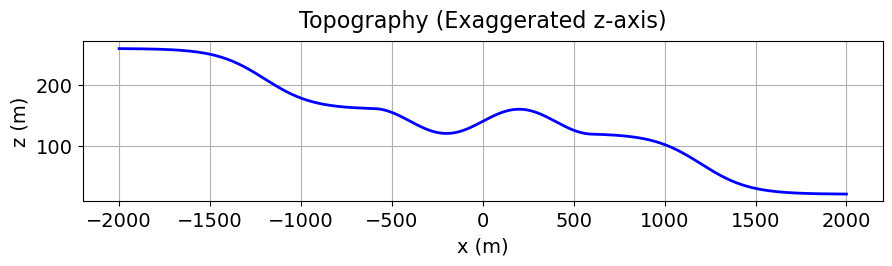

In [3]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

## Define the survey

First using fake survey set up, later can make this more like what the real data survey is

In [4]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = np.r_[-400.0, 400.0]  # along-line position
station_separation = 40.0
num_rx_per_src = 10

In [5]:
# Define linear interpolation function for elevation
interp_fun = interp1d(x_topo, z_topo)

In [6]:
# Define electrode locations
electrode_locations_x = np.arange(
    end_locations[0], end_locations[1] + station_separation, station_separation
)
electrode_locations_z = interp_fun(electrode_locations_x)
electrode_locations = np.c_[electrode_locations_x, electrode_locations_z]

# Number of electrode locations
n_electrodes = len(electrode_locations_x)

In [7]:
# Instantiate empty list for sources
source_list = []

ii = 0
while ii < n_electrodes - 3:
    # A and B electrode locations
    location_a = electrode_locations[ii, :]
    location_b = electrode_locations[ii + 1, :]

    # M and N electrode locations
    ii_max = np.min([ii + 3 + num_rx_per_src, n_electrodes])
    locations_m = electrode_locations[ii + 2 : ii_max - 1]
    locations_n = electrode_locations[ii + 3 : ii_max]

    # Define receivers for source ii
    receivers_list = [
        dc.receivers.Dipole(
            locations_m=locations_m, locations_n=locations_n, data_type=data_type
        )
    ]

    # Append source ii to list
    source_list.append(
        dc.sources.Dipole(receivers_list, location_a=location_a, location_b=location_b)
    )

    ii += 1

# Define survey
survey = dc.Survey(source_list)

Tutorial also gives options for generating the survey from real ABMN locations or a set of survey lines. Not followed here.

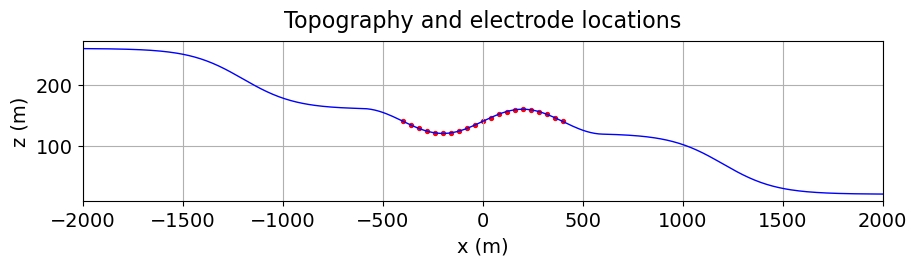

In [8]:
# plot survey locations

fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, color="b", linewidth=1)
ax.scatter(electrode_locations_x, electrode_locations_z, 8, "r")
ax.set_xlim([x_topo.min(), x_topo.max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and electrode locations", fontsize=16, pad=10)
plt.show(fig)

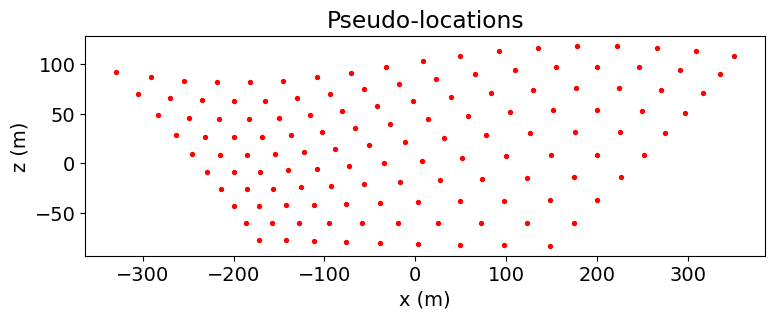

In [9]:
# plot pseudo-

pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Pseudo-locations")
plt.show()

## Design a Tree Mesh

Uses discretize package. Electrode potential falls off as $r^{-3}$ so smaller cells at top and larger away from them. Considerations are as follows:

* No currents in the air, no padding upwards needed, top of mesh is top of topography.
* At least 2-3 cells between current electrodes. More accurate with smaller cells.
* Padding thickness at least 2-3 times the largest electrode spacing.
* Increase ain cell size shouldn't happen too abruptly, at least 4 cells thick before increasing.
* Finer discretization when topography is significant.

In [10]:
#define mesh

dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, z_topo.max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[8, 12, 6, 6], finalize=False
)

mesh.finalize()

In [11]:
# print properties

print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 12311
# of x-faces: 12224
Origin: [-2048.         -1788.24726232]
Max cell volume: 262144.0
[[-1792.         -1532.24726232]
 [-1280.         -1532.24726232]
 [-1792.         -1020.24726232]
 [-1280.         -1020.24726232]
 [ -768.         -1532.24726232]]


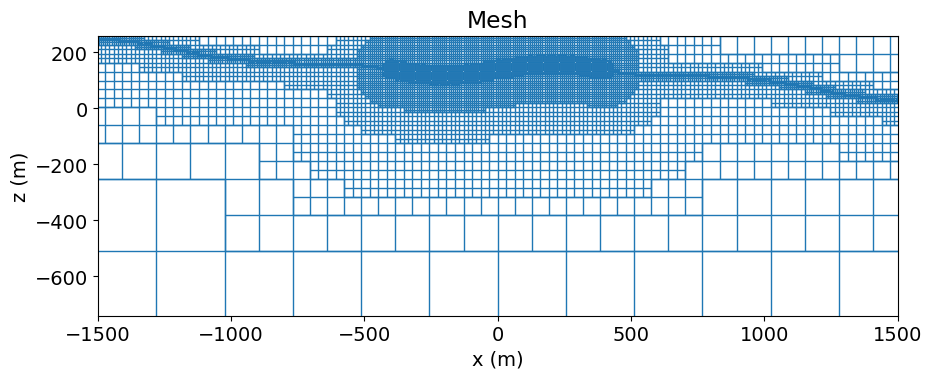

In [12]:
# plot mesh

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(-1500, 1500)
ax1.set_ylim(np.max(z_topo) - 1000, np.max(z_topo))
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()


## Define active cells

i.e. set the cells above the surface as 'inactive cells' as their physical properties are fixed

In [13]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Define and plot the model

Again, using that from the tutorial, not my own for now

In [14]:
air_conductivity = 1e-8 #NOT set to 0, ensures linear system to solve PDE is well-conditioned
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

In [15]:
# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-120.0, 40.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_conductor] = conductor_conductivity

ind_resistor = model_builder.get_indices_sphere(
    np.r_[120.0, 72.0], 60.0, mesh.cell_centers[active_cells, :]
)
conductivity_model[ind_resistor] = resistor_conductivity

# Define log-resistivity model
log_resistivity_model = np.log(1 / conductivity_model)

In [16]:
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, air_conductivity)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, 1 / air_conductivity
) * maps.ExpMap(nP=n_active)

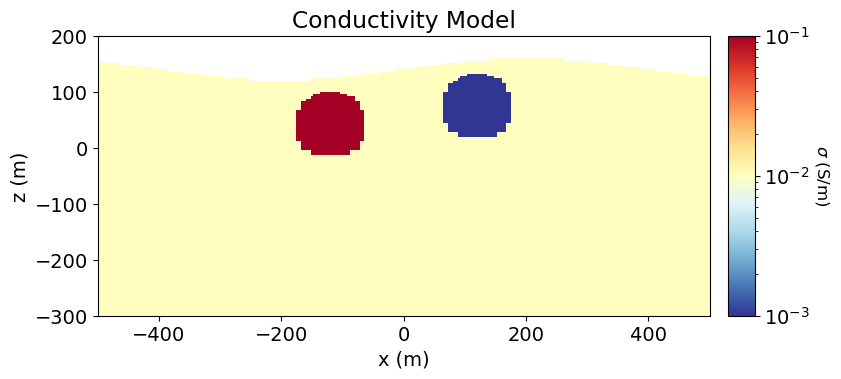

In [17]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e-3, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

In [18]:
# make sure the electrodes are mapped to being ON the surface, not below or especially not above
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define Forward Simulation

Could also use Simulation2DCellCentered but Simulation2DNodel defines the electrical potential at nodes and is more well-suited for SURFACE resistivity data. Cell Centered good for borehole data.

Muse connect the simulation object to
* the survey
* the mesh
* the mapping from the model to the mesh
by setting each of these as a property of the simulation object.

In [19]:
conductivity_map

In [20]:
# DC simulation for a conductivity model
simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map, solver=get_default_solver()
)

#second option
# DC simulation for a log-resistivity model
simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=log_resistivity_map
)

## Get predicted data

The con and res methods give the same results, it just depends how you define the models (resistivity or conductivity)

In [21]:
solver = get_default_solver()
solver

pymatsolver.direct.mumps.Mumps

In [22]:
#throws runtime error thats wrapped within a simpeg function, but still works
dpred_con = simulation_con.dpred(conductivity_model)

/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


In [23]:
#throws runtime error thats wrapped within a simpeg function, but still works
dpred_res = simulation_res.dpred(log_resistivity_model)

/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


In [24]:
print("MAX ABSOLUTE ERROR = {}".format(np.max(np.abs(dpred_con - dpred_res))))

MAX ABSOLUTE ERROR = 1.6930901125533637e-15


## Plot in pseudosection

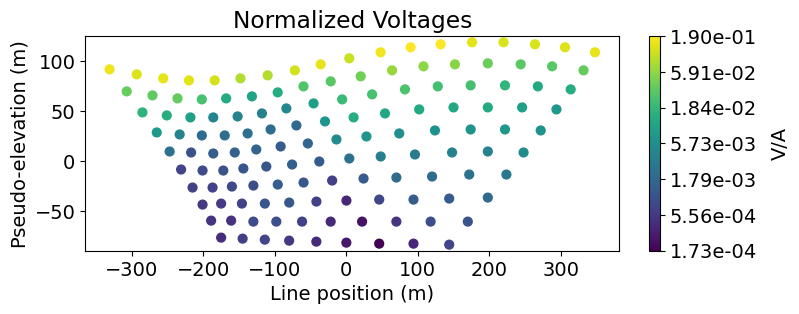

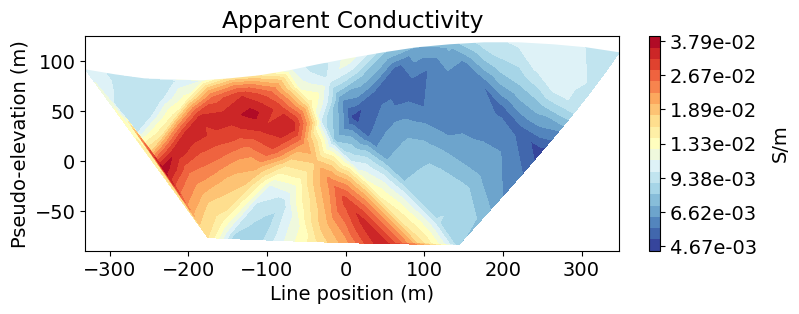

In [25]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=np.abs(dpred_con),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_conductivities = 1 / apparent_resistivity_from_voltage(survey, dpred_con)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=apparent_conductivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Conductivity")
plt.show()

# INVERSION

## Load tutorial data and plot

In [26]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/inv_dcr_2d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_2d.txt"
data_filename = dir_path + "dc_data.obs"

overwriting /Users/cara/repos/eosc-556-project/inv_dcr_2d_files.tar.gz
   saved to: /Users/cara/repos/eosc-556-project/inv_dcr_2d_files.tar.gz
Download completed!


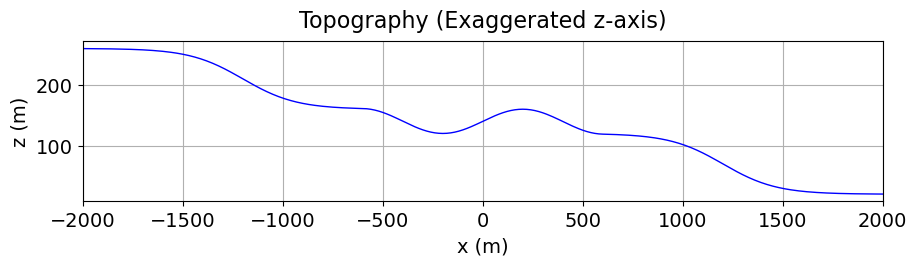

In [27]:
# Load 2D topography
topo_2d = np.loadtxt(str(topo_filename))

# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, -1], color="b", linewidth=1)
ax.set_xlim([topo_2d[:, 0].min(), topo_2d[:, 0].max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

In [28]:
# read in data. Here will need to work out how to read in the real data to this format (says how in the tutorial)

voltage_data = read_dcip2d_ubc(data_filename, "volt", "general")

## Plot pseudosection

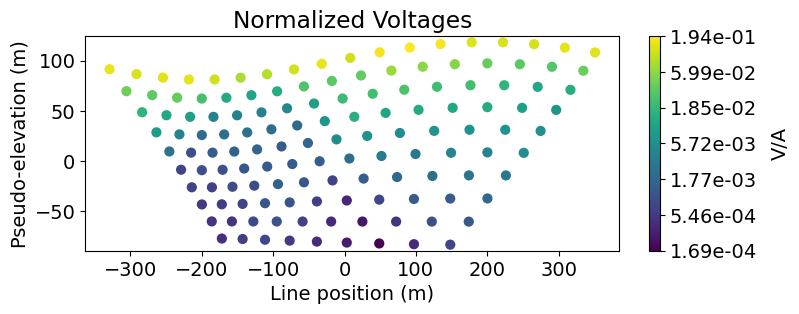

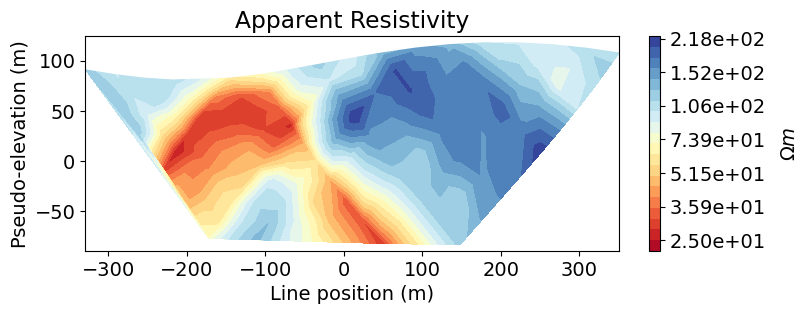

In [29]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(
    voltage_data.survey, voltage_data.dobs
)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Assign uncertainties, project electrodes to discretized topography

In [30]:
# Apply uncertainties to normalized voltage data
voltage_data.standard_deviation = 1e-7 + 0.05 * np.abs(voltage_data.dobs)

voltage_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Map from model to mesh



In [31]:
# Map model parameters to all cells
log_conductivity_map = maps.InjectActiveCells(mesh, active_cells, 1e-8) * maps.ExpMap(
    nP=n_active
)

## Starting model, median of the apparent resistivities

In [32]:
# Median apparent resistivity
median_resistivity = np.median(apparent_resistivities)

# Create starting model from log-conductivity
starting_conductivity_model = np.log(1 / median_resistivity) * np.ones(n_active)

# Zero reference conductivity model
reference_conductivity_model = starting_conductivity_model.copy()

## Forward simulation

In [33]:
voltage_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=voltage_data.survey, sigmaMap=log_conductivity_map, storeJ=True
)

## Data misfit (L2 norm)

In [34]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=voltage_simulation, data=voltage_data)

## Regularization

In [35]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    alpha_s=dh**-2,
    alpha_x=1,
    alpha_y=1,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

## Optimization

In [36]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=40, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Inverse problem

In [37]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

## Inversion directives

In [38]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

## Design and run inversion

In [39]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
#throws an error/warning thats wrapped within a simpeg function, but still works
recovered_log_conductivity_model = inv_L2.run(starting_conductivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.81e+01  4.45e+04  0.00e+00  4.45e+04    5.33e+03      0              
   1  2.81e+01  1.78e+03  5.87e+01  3.43e+03    4.19e+02      0              
   2  1.40e+01  5.06e+02  7.75e+01  1.59e+03    8.76e+01      0   Skip BFGS  
   3  1.40e+01  2.54e+02  8.83e+01  1.49e+03    8.21e+00      0   Skip BFGS  
   4  7.02e+00  2.56e+02  8.85e+01  8.78e+02    5.01e+01      0              
   5  7.02e+00  1.51e+02  9.49e+01  8.17e+02    4.60e+00      0              
   6  3.51e+00  1.50e+02  9.54e+01  4.85e+02    2.56e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.4540e+03
1 : |xc-x_last| = 2.6816e+00 <= tolX*(1+|x0|) = 3.8989e+01
0 : |p

## Plot misfit

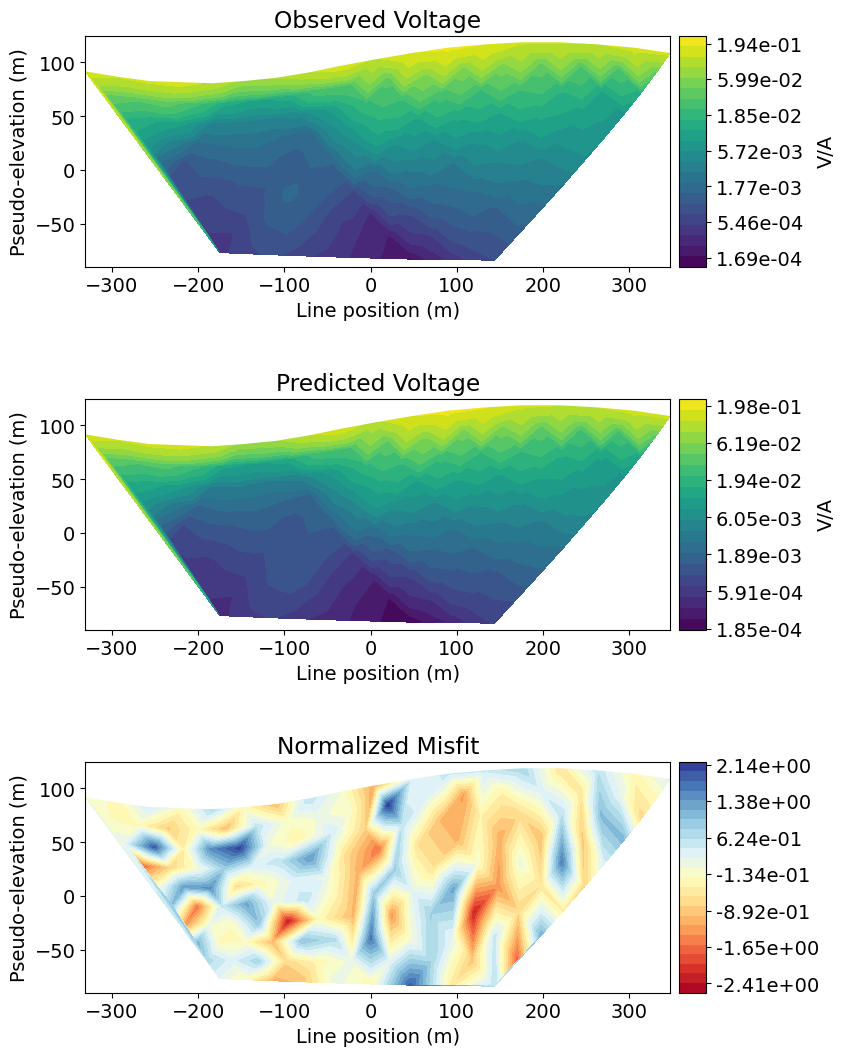

In [40]:
# Predicted data from recovered model
dpred = inv_prob_L2.dpred
dobs = voltage_data.dobs
std = voltage_data.standard_deviation

# Plot
fig = plt.figure(figsize=(9, 11))
data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred) / std]
plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        voltage_data.survey,
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

## Plot recovered model

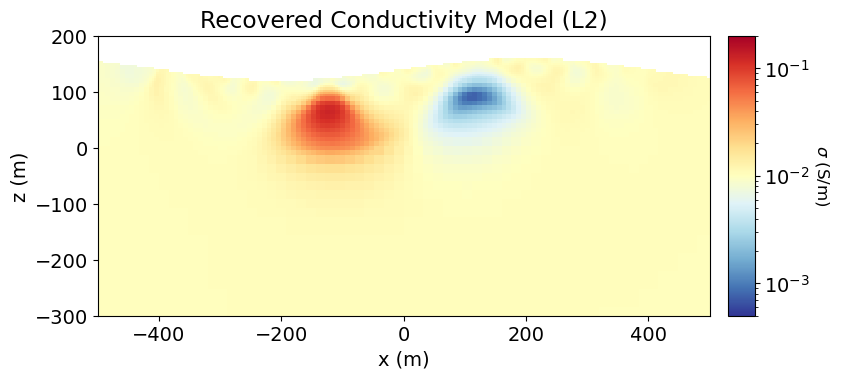

In [41]:
# Convert log-conductivity values to conductivity values
recovered_conductivity_L2 = np.exp(recovered_log_conductivity_model)

# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

norm = LogNorm(vmin=5e-4, vmax=2e-1)

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_conductivity_L2,
    normal="Y",
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-500, 500)
ax1.set_ylim(-300, 200)
ax1.set_title("Recovered Conductivity Model (L2)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()